<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2023/blob/main/Module%204/13_PCA_CL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial notebook for the Fall 2023 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin
- Data by Mahshid Ahmadi and Jonghee Yang (UT Knoxville)
- Sample from Juan Pablo Correa-Baena group (GaTech)
- CL measurements by Ben Lawrie (ORNL)

In [1]:
from copy import deepcopy as dc

import numpy as np
import torch
import h5py

from scipy import ndimage
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Data download

Here we download the cathodoluminescence (https://en.wikipedia.org/wiki/Cathodoluminescence) data from several smaples of hybrid perovskites. These materials are prone to the formation of the impurity PbI2 phase that can be identified via CL emission at a speciifc wavelength.

In [2]:
# MA-free Perovskites (Cs0.17Pb0.83PbI3 = RT, 150, 200, 250 C)

!gdown https://drive.google.com/uc?id=1uCfAKlk5KTnsgNJQiiOsjdsvBx2CMzE1
!gdown https://drive.google.com/uc?id=1TTNNnmIS2b1HW8q7ywLbBRhUUBdTm1KU
!gdown https://drive.google.com/uc?id=195ih426XxtRAlidtxzSA5nIRemP3SvML
!gdown https://drive.google.com/uc?id=1cBfegFNV782WCIEKAn_hDA2RgtAJQkAx

#20220510_D17_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_3g_corrected #RT
#0220415_D45_30kx_5kV_32pA_LV_200ms_119X80_40nm_1_corrected #150C
#0220415_D48_30kx_5kV_32pA_LV_400ms_119X80_40nm_2_corrected #200C
#0220418_D50_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_8g_re_corrected #250C

Downloading...
From: https://drive.google.com/uc?id=1uCfAKlk5KTnsgNJQiiOsjdsvBx2CMzE1
To: /content/20220510_D17_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_3g_corrected.h5
100% 49.5M/49.5M [00:00<00:00, 61.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TTNNnmIS2b1HW8q7ywLbBRhUUBdTm1KU
To: /content/0220415_D45_30kx_5kV_32pA_LV_200ms_119X80_40nm_1_corrected.h5
100% 19.8M/19.8M [00:00<00:00, 51.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=195ih426XxtRAlidtxzSA5nIRemP3SvML
To: /content/0220415_D48_30kx_5kV_32pA_LV_400ms_119X80_40nm_2_corrected.h5
100% 19.7M/19.7M [00:00<00:00, 31.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cBfegFNV782WCIEKAn_hDA2RgtAJQkAx
To: /content/0220418_D50_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_8g_re_corrected.h5
100% 15.4M/15.4M [00:00<00:00, 70.9MB/s]


In [3]:
h5_f1 = h5py.File(r'/content/20220510_D17_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_3g_corrected.h5', 'r+')
h5_f2 = h5py.File(r'/content/0220415_D45_30kx_5kV_32pA_LV_200ms_119X80_40nm_1_corrected.h5', 'r+')
h5_f3 = h5py.File(r'/content/0220415_D48_30kx_5kV_32pA_LV_400ms_119X80_40nm_2_corrected.h5', 'r+')
h5_f4 = h5py.File(r'/content/0220418_D50_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_8g_re_corrected.h5', 'r+')

Let's dig into the structure of the hdf5 file a bit. Generally, these are built for specific insturment and with the strucutre general enough to accomodate all possible modalities of the specific instrument. Practically, we need to find out the element of the hdf5 file that contains the data we need - a bit like exploring the hierarchical tree of folders (its unsurprising - hdf stands for hierarchical data format)

In [4]:
print(h5_f1.keys())
print(h5_f1['Acquisition2'].keys())
print(h5_f1['Acquisition2']['ImageData'].keys())

<KeysViewHDF5 ['Acquisition0', 'Acquisition1', 'Acquisition2']>
<KeysViewHDF5 ['ImageData', 'PhysicalData', 'SVIData', 'StateEnumeration']>
<KeysViewHDF5 ['DimensionScaleC', 'DimensionScaleX', 'DimensionScaleY', 'DimensionScaleZ', 'Image', 'PrimaryGlassMediumInterfacePosition', 'SecondaryGlassMediumInterfacePosition', 'TOffset', 'XOffset', 'YOffset', 'ZOffset']>


(1, 1, 1, 3840, 5760)


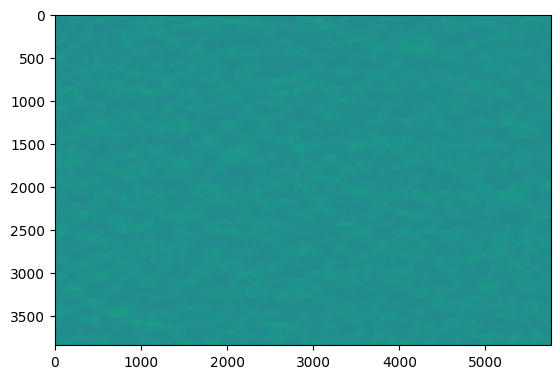

In [5]:
print(h5_f1['Acquisition0']['ImageData']['Image'].shape)
im0 = np.squeeze(h5_f1['Acquisition0']['ImageData']['Image'])
plt.imshow(im0)

(1, 1, 1, 1280, 1904)


(-0.5, 1903.5, 1279.5, -0.5)

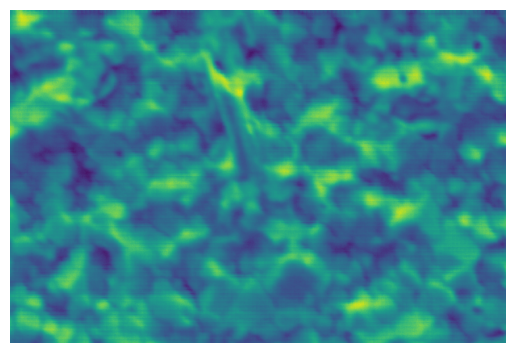

In [6]:
print(h5_f1['Acquisition1']['ImageData']['Image'].shape)
im1 = np.squeeze(h5_f1['Acquisition1']['ImageData']['Image'])
plt.imshow(im1)
plt.axis('off')

(1024, 1, 1, 80, 119)


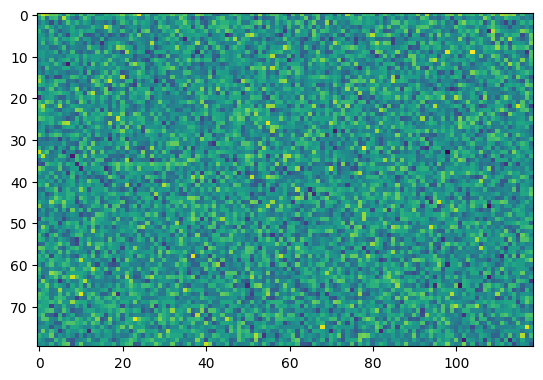

In [7]:
print(h5_f1['Acquisition2']['ImageData']['Image'].shape)
im2 = np.squeeze(h5_f1['Acquisition2']['ImageData']['Image'])
plt.imshow(im2[200,:,:])

Thsi looks like a spectral data that we need. Let's take it.

In [8]:
dataset = im2.astype(np.float64)
print(dataset.shape)
d1, d2, d3 = dataset.shape
dataset = dataset.reshape(d1, d2*d3)

(1024, 80, 119)


The sampling of the data is too large. Let's just average pool it.

In [9]:
y = torch.from_numpy(np.array(dataset.T))[:, None]
y = torch.nn.functional.avg_pool1d(y, 8, 8).squeeze().numpy()
print(y.shape)
_, s1 = y.shape

(9520, 128)


In [10]:
y = y.reshape(d2, d3, s1)
y.shape

(80, 119, 128)

In [11]:
hdata = y
hdata = hdata.astype(np.float64)

Visual inspection:

# Visual inspection

505.33000000000004 793.5844 800.4476 443.5612


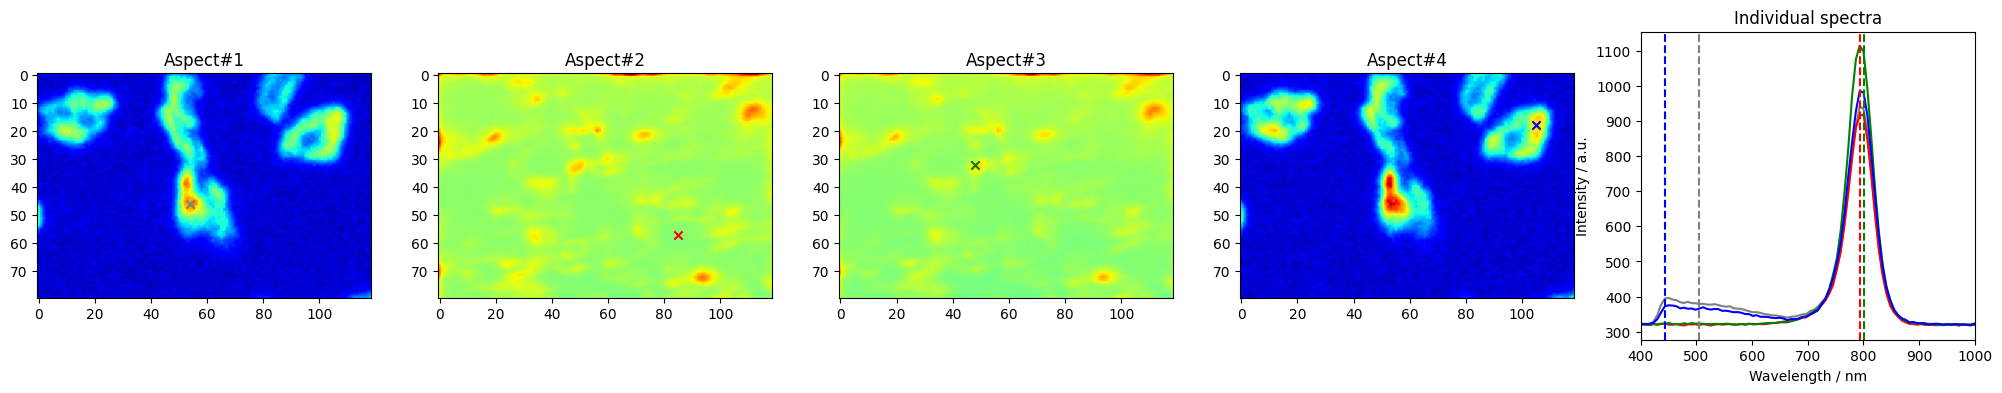

In [12]:
x=np.linspace(162.17, 1033.31, 128)
wavelength = x

# Select a slice and points for extracting idividual spectoscopic 162.17, 1033.31,1024
s1 = 50 # slice
s2 = 92 # slice
s3 = 93 # slice
s4 = 41 # slice
s5 = 50 # slice

pos1 = [54, 46] # Aspect1
pos2 = [85, 57] # Aspect2
pos3 = [48, 32] # Aspect3
pos4 = [105, 18] # Aspect4

# Plot
_, ax = plt.subplots(1, 5, figsize=(25, 4))
ax[0].imshow(hdata[..., s1], cmap='jet', origin="upper", vmin = 315, vmax = 400)
ax[0].scatter(pos1[0], pos1[1], c='gray', marker='x')
ax[1].imshow(hdata[..., s2], cmap='jet', origin="upper", vmin = 315, vmax = 1500)
ax[1].scatter(pos2[0], pos2[1], c='red', marker='x')
ax[2].imshow(hdata[..., s3], cmap='jet', origin="upper", vmin = 315, vmax = 1500)
ax[2].scatter(pos3[0], pos3[1], c='green', marker='x')
ax[3].imshow(hdata[..., s4], cmap='jet', origin="upper", vmin = 315, vmax = 400)
ax[3].scatter(pos4[0], pos4[1], c='blue', marker='x')
ax[4].plot(wavelength, hdata[pos1[1], pos1[0], :], c='gray')
ax[4].plot(wavelength, hdata[pos2[1], pos2[0], :], c='red')
ax[4].plot(wavelength, hdata[pos3[1], pos3[0], :], c='green')
ax[4].plot(wavelength, hdata[pos4[1], pos4[0], :], c='blue')
ax[4].axvline(x=s1*0.8579*8+162.17, linestyle = '--', c='gray')
ax[4].axvline(x=s2*0.8579*8+162.17, linestyle = '--', c='red')
ax[4].axvline(x=s3*0.8579*8+162.17, linestyle = '--', c='green')
ax[4].axvline(x=s4*0.8579*8+162.17, linestyle = '--', c='blue')
ax[0].set_title('Aspect#1')
ax[1].set_title('Aspect#2')
ax[2].set_title('Aspect#3')
ax[3].set_title('Aspect#4')
ax[4].set_title('Individual spectra')
ax[4].set_xlabel('Wavelength / nm')
ax[4].set_ylabel('Intensity / a.u.')
ax[4].set_xlim(400, 1000)

print(s1*0.8579*8+162.17,s2*0.8579*8+162.17,s3*0.8579*8+162.17,s4*0.8579*8+162.17)

Let's plot images so we can use them as a figure

505.33000000000004 793.5844 800.4476 443.5612 505.33000000000004


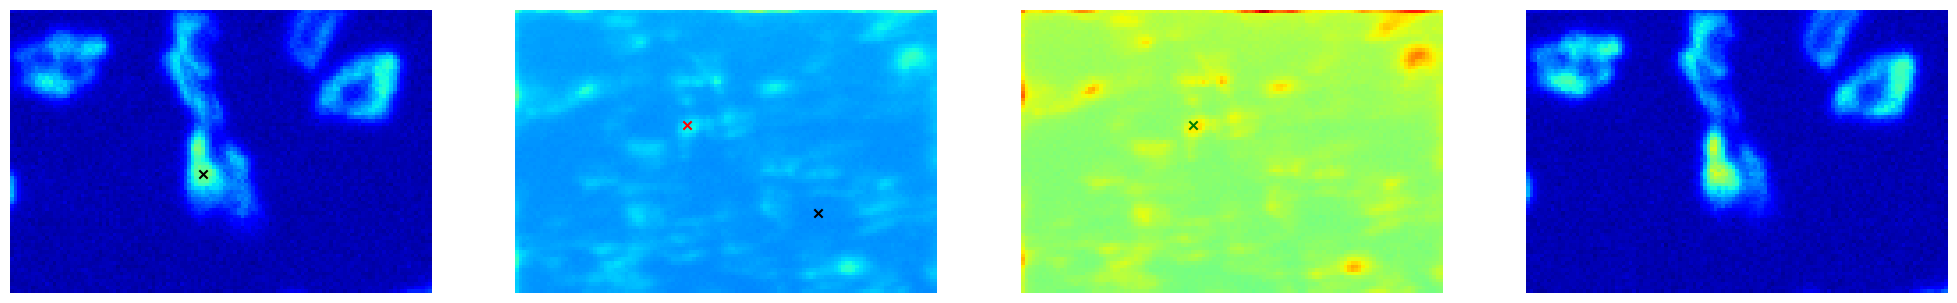

In [13]:
# Plot
_, ax = plt.subplots(1, 4, figsize=(25, 5))
ax[0].imshow(hdata[..., s1], cmap='jet', origin="upper", vmin = 315, vmax = 450)
ax[0].scatter(pos1[0], pos1[1], c='black', marker='x')
ax[1].imshow(hdata[..., s2], cmap='jet', origin="upper", vmin = 315, vmax = 2600)
ax[1].scatter(pos2[0], pos2[1], c='black', marker='x')
ax[1].scatter(pos3[0], pos3[1], c='red', marker='x')
ax[2].imshow(hdata[..., s3], cmap='jet', origin="upper", vmin = 315, vmax = 1500)
ax[2].scatter(pos3[0], pos3[1], c='green', marker='x')
ax[3].imshow(hdata[..., s4], cmap='jet', origin="upper", vmin = 315, vmax = 450)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
#ax[0].set_title('Aspect#1')
#ax[1].set_title('Aspect#2')
#ax[2].set_title('Aspect#3')
#ax[3].set_title('Aspect#4')

print(s1*0.8579*8+162.17,s2*0.8579*8+162.17,s3*0.8579*8+162.17,s4*0.8579*8+162.17,s5*0.8579*8+162.17)

(80, 119, 128) (80, 119)
(80, 119)
(80, 119, 128) (80, 119)
(80, 119)
(80, 119, 128) (80, 119)
(80, 119)
(80, 119, 128) (80, 119)
(80, 119)


Text(0, 0.5, 'Intensity / a.u.')

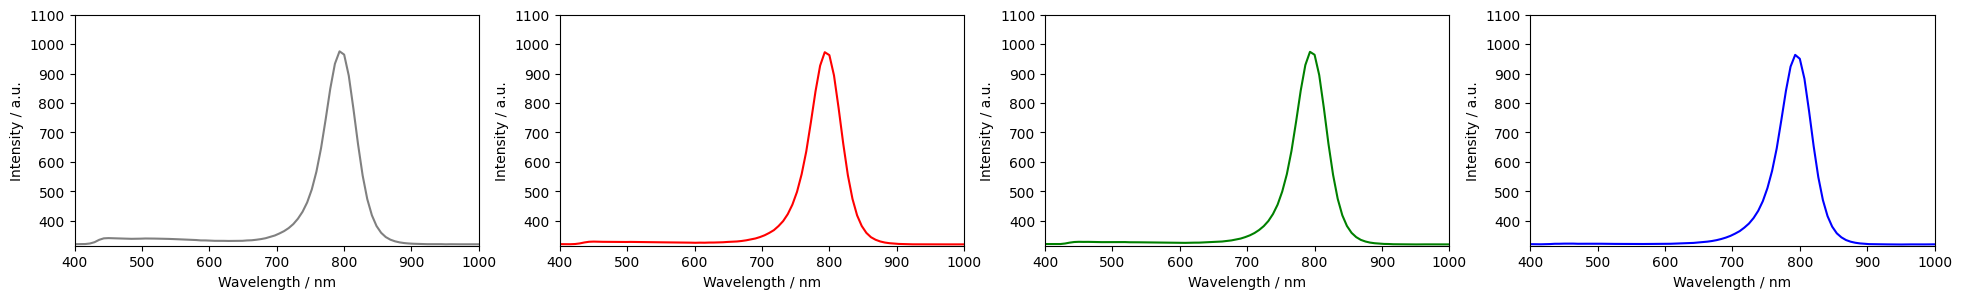

In [14]:
#Averaged spectra over each region
im_s1 = hdata[..., s1]
print(hdata.shape, im_s1.shape)
print(im_s1.shape)
av_sp1 = hdata[..., s1, :].mean(axis = 0)
im_s2 = hdata[..., s2]
print(hdata.shape, im_s2.shape)
print(im_s2.shape)
av_sp2 = hdata[..., s2, :].mean(axis = 0)
im_s3 = hdata[..., s3]
print(hdata.shape, im_s3.shape)
print(im_s3.shape)
av_sp3 = hdata[..., s3, :].mean(axis = 0)
im_s4 = hdata[..., s4]
print(hdata.shape, im_s4.shape)
print(im_s4.shape)
av_sp4 = hdata[..., s4, :].mean(axis = 0)

_, ax = plt.subplots(1, 4, figsize=(24,3))
ax[0].plot(wavelength, av_sp1, c='gray')
ax[1].plot(wavelength, av_sp2, c='red')
ax[2].plot(wavelength, av_sp3, c='green')
ax[3].plot(wavelength, av_sp4, c='blue')
ax[0].set_xlabel('Wavelength / nm')
ax[0].set_ylabel('Intensity / a.u.')
ax[0].set_xlim(400,1000)
ax[1].set_xlim(400,1000)
ax[2].set_xlim(400,1000)
ax[3].set_xlim(400,1000)
ax[0].set_ylim(315,1100)
ax[1].set_ylim(315,1100)
ax[2].set_ylim(315,1100)
ax[3].set_ylim(315,1100)
ax[1].set_xlabel('Wavelength / nm')
ax[1].set_ylabel('Intensity / a.u.')
ax[2].set_xlabel('Wavelength / nm')
ax[2].set_ylabel('Intensity / a.u.')
ax[3].set_xlabel('Wavelength / nm')
ax[3].set_ylabel('Intensity / a.u.')

(315.0, 1200.0)

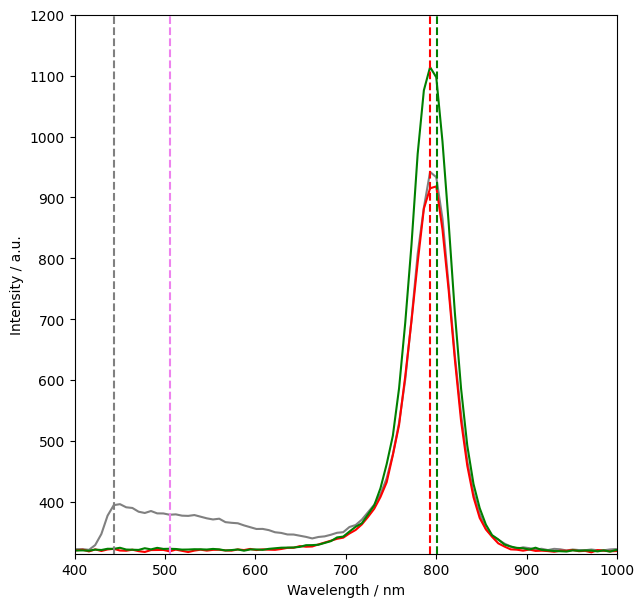

In [15]:
plt.figure(figsize=(7,7))
plt.plot(wavelength, hdata[pos1[1], pos1[0], :], c='gray')
plt.plot(wavelength, hdata[pos2[1], pos2[0], :], c='red')
plt.plot(wavelength, hdata[pos3[1], pos3[0], :], c='green')

plt.axvline(x=s4*0.8579*8+162.17, linestyle = '--', c='gray')
plt.axvline(x=s2*0.8579*8+162.17, linestyle = '--', c='red')
plt.axvline(x=s3*0.8579*8+162.17, linestyle = '--', c='green')

plt.axvline(x=s5*0.8579*8+162.17, linestyle = '--', c='violet')
plt.xlabel('Wavelength / nm')
plt.ylabel('Intensity / a.u.')
plt.xlim(400, 1000)
plt.ylim(315, 1200)

- Here, we can see that we have a strong peak at around 800 nm. The position of this peak and its height/width can change a bit. We also see that some of the locations have a pre-peak at the 450-600 nm. Less obvious is that the main peak can also have a shoulder.

- The great thing about the CL data is that it is with a very good approximation linear - the signal from multiple phases is a sum of signals from individual phases

- And finally CL signal from pure material will have a nice Lorenzian peak shape (can become Gaussian if there is some dosprder) - so we can expect shape of the peaks to be meaningful as well

- So for this system, we can expect that both ML analysis using linear methods and physics-based analysis will be useful.

- Let's try both!

# PCA and NMF

First, we start with exploratory data analysis using PCA and NMF (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization).

- Remember that PCA components are orthogonal, and we use truncation to select desired number of components

- NMF components are positively-defined, and we need to choose how many NMF components to use.

In [16]:
X_vec = hdata.copy()
d1, d2, d3 = X_vec.shape
X_vec = X_vec.reshape(d1*d2, d3)
X_vec = (X_vec - np.min(X_vec)) / np.ptp(X_vec)

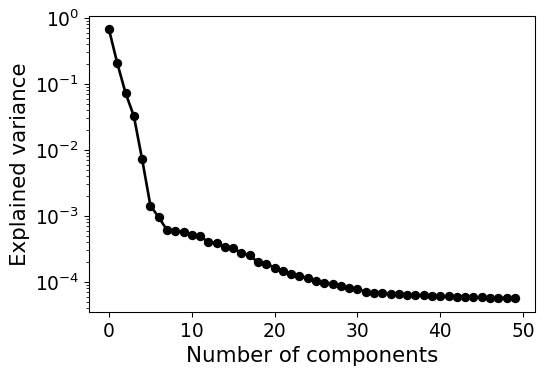

In [17]:
pca = decomposition.PCA()
pca.fit(X_vec)
plt.figure(figsize=(6, 4), dpi = 96)
plt.plot(pca.explained_variance_ratio_[0:50], '-o', linewidth=2, c = 'black')
plt.xlabel('Number of components', fontsize = 16)
plt.ylabel('Explained variance', fontsize = 16)

plt.tick_params(labelsize = 14)
plt.yscale('log')

In [18]:
# Select number of components
nc = 5

# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'PCA'

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

(5, 128) (9520, 5)


NUMBER OF COMPONENTS: 5
Components...


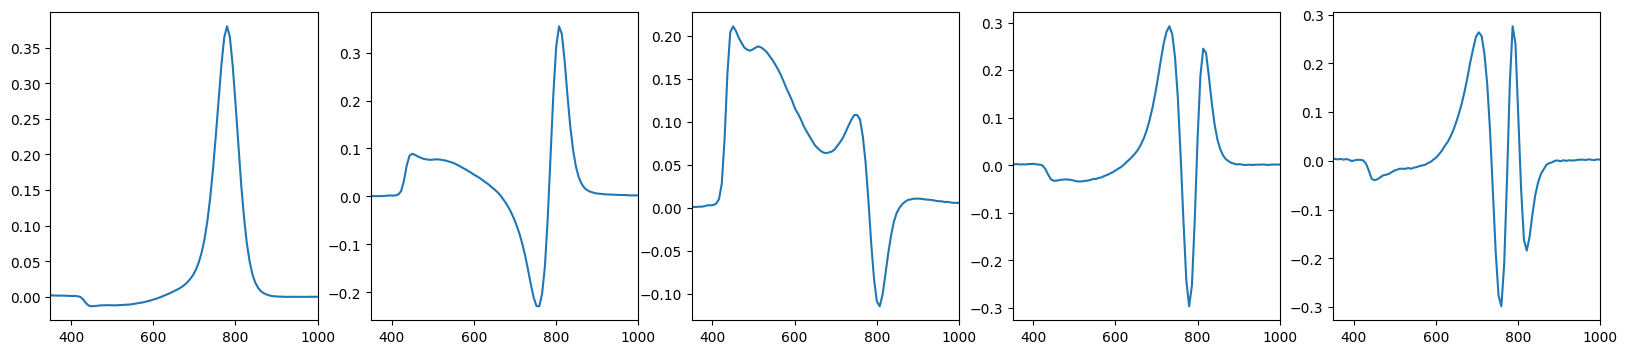

Abundance maps...


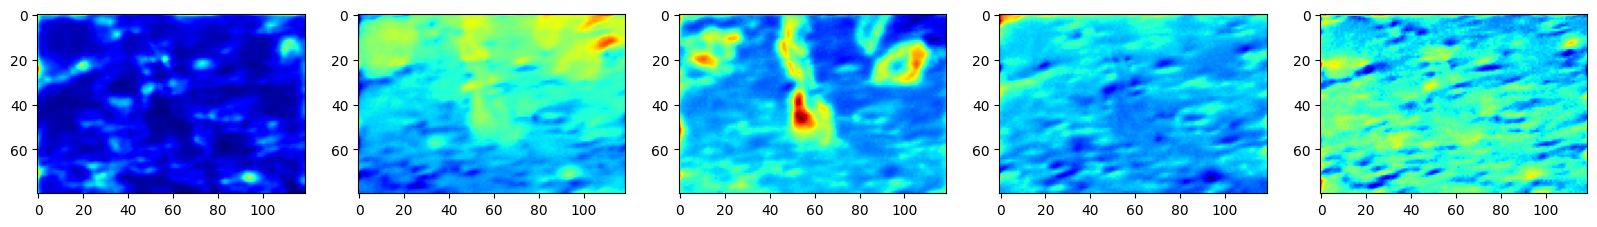

In [19]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 3.5*(1+rows)//1.5))
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    ax1.plot(wavelength, components[i])
    #ax1.set_title('Component ' + str(i + 1))
    ax1.set_xlim(350,1000)
plt.show()

print('Abundance maps...')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(X_vec_t[:, i].reshape(d1, d2), cmap = 'jet')
    #ax2.set_title('Component ' + str(i + 1))
plt.show()

Looks like we have quite rich structure in this material!
- Experiment witht he number of the PCA and NMF components
- What do you see?
- ANy guesses how we can (qualitativley) interpret them in terms of peak positions, shifts, etc?

# Masking and analysis

We can use the PCA and NMF maps to build masks that select the regions we *think* is interetsing, and average the spectra from these regions.

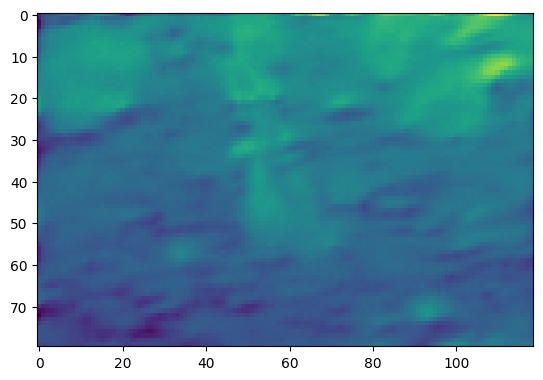

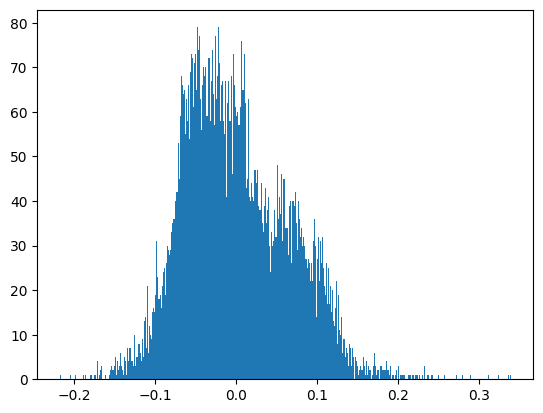

In [20]:
# Choose the image:
im_an = X_vec_t[:, 1].reshape(d1, d2)
plt.imshow(im_an)
plt.show()

# Make histogram to choose offsets
plt.hist(im_an.flatten(), bins = 500)
plt.show()

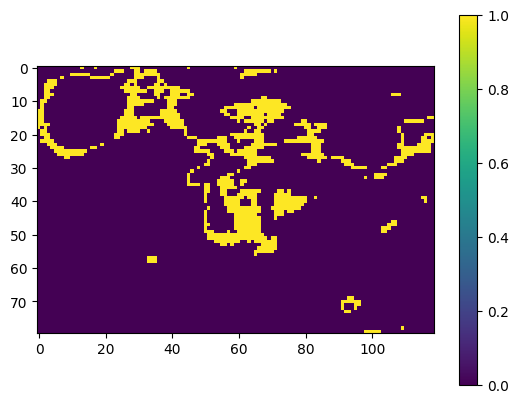

In [21]:
# Select offsets manually
# Play with the logic (i.e. > and <)
off1, off2 = 0.02, 0.05
im_cut = (im_an > off1) & (im_an < off2)

# And check binary mask (ones and zeros)
plt.imshow(im_cut)
plt.colorbar()
plt.show()

(80, 119, 128) (80, 119)
(1018, 128)


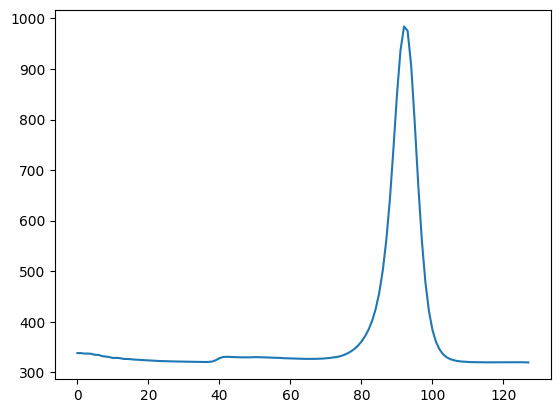

In [22]:
# We use indexing to average spectra
# Only within yellow regions

print(hdata.shape, im_cut.shape)
print(hdata[im_cut, :].shape)
av_spec = hdata[im_cut, :].mean(axis = 0)
plt.plot(av_spec)

In [23]:
im_cut.sum()

1018

# Supervised regression

- The simplest example of the supervised analysis method is supervised linear regression. Here, we try to represent the spectrum at each location as a linear ocmbination of example spectra.
- Here, we are going to choose the "known" locations on the PCA maps to produce these endmember spectra.

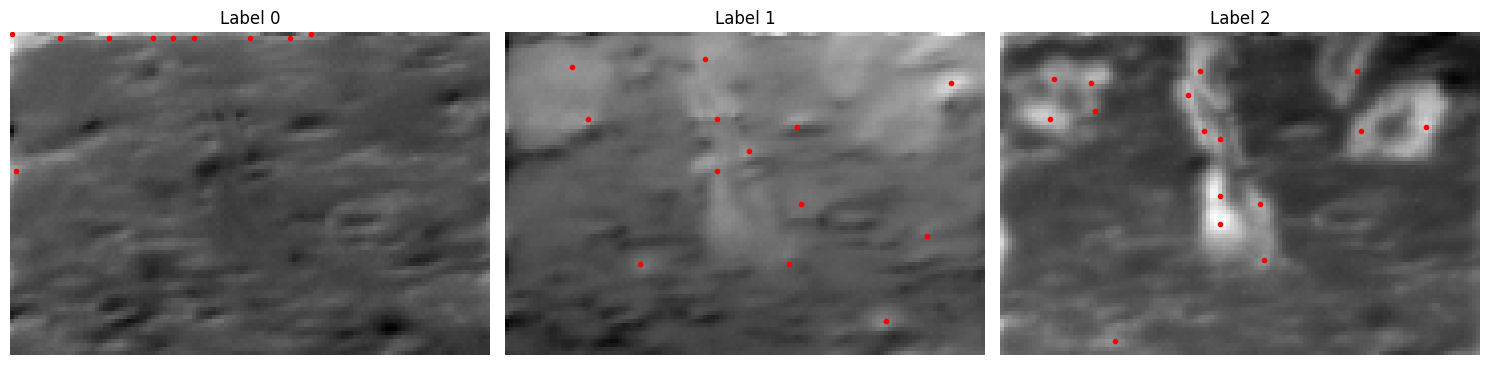

(10, 128) (13, 128) (16, 128)


In [24]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

train_data = hdata
X_train = np.array(train_data)

im0 = X_vec_t[:, 3].reshape(d1, d2)
image_max0 = ndi.maximum_filter(im0, size=2, mode='constant')
coordinates0 = peak_local_max(image_max0, min_distance=3, threshold_abs = 0.08, exclude_border = False)
label0 = np.array([X_train.reshape(d1,d2,d3)[i,j,:] for i,j in coordinates0])

im1 = X_vec_t[:, 1].reshape(d1, d2)
image_max1 = ndi.maximum_filter(im1, size=4, mode='constant')
coordinates1 = peak_local_max(image_max1, min_distance=6, threshold_abs = 0.0025, exclude_border = True)
label1 = np.array([X_train.reshape(d1,d2,d3)[i,j,:] for i,j in coordinates1])

im2 = X_vec_t[:, 2].reshape(d1, d2)
image_max2 = ndi.maximum_filter(im2, size=2, mode='constant')
coordinates2 = peak_local_max(image_max2, threshold_abs = 0.05, min_distance=3)
label2 = np.array([X_train.reshape(d1,d2,d3)[i,j,:] for i,j in coordinates2])

# display results
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

ax = axes.ravel()
ax[0].imshow(im0, cmap=plt.cm.gray)
ax[0].plot(coordinates0[:, 1], coordinates0[:, 0], 'r.')
ax[0].axis('off')
ax[0].set_title('Label 0')

ax[1].imshow(im1, cmap=plt.cm.gray)
ax[1].plot(coordinates1[:, 1], coordinates1[:, 0], 'r.')
ax[1].axis('off')
ax[1].set_title('Label 1')

ax[2].imshow(im2, cmap=plt.cm.gray)
ax[2].plot(coordinates2[:, 1], coordinates2[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Label 2')

fig.tight_layout()

plt.show()

print(label0.shape, label1.shape, label2.shape)

In [25]:
imstack_train_s = np.concatenate((label0, label1, label2))

labels_train_s = np.concatenate((np.zeros(len(label0)),
                                 np.zeros(len(label1))+1,
                                 np.zeros(len(label2))+2))

print(imstack_train_s.shape, labels_train_s.shape)

(39, 128) (39,)


Supervised regression is exactly what it souds like. Since we have already created examples of classes for the ss-VAE, we can see if the linear model works. Generally for many data set, it does work very well (since image formation mechanisms is linear). Caveat of course is that you have to know all examples.  

Text(0.5, 1.0, 'Label surface')

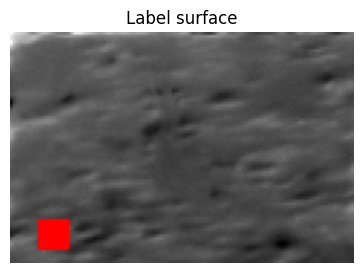

In [26]:
coordinates_surf = np.array([[i+65,j+10] for i in range(10) for j in range(10)])

plt.figure(figsize=(8, 3))
plt.imshow(im0, cmap=plt.cm.gray)
plt.plot(coordinates_surf[:, 1], coordinates_surf[:, 0], 'r.')
plt.axis('off')
plt.title('Label surface')

(80, 119, 128)


(400.0, 1000.0)

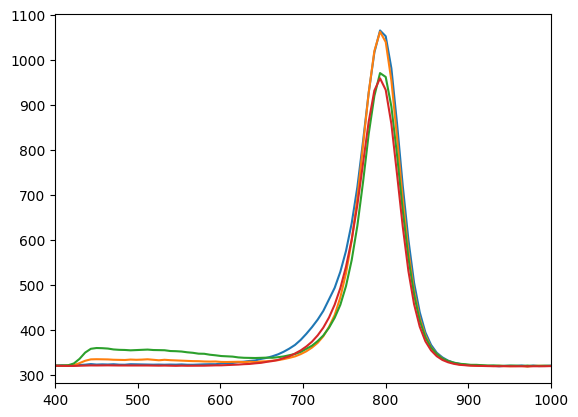

In [27]:
X_vec2 = hdata.reshape(d1, d2, d3)
print(X_vec2.shape)

surf = np.array([X_vec2[i,j,:] for i,j in coordinates_surf]).mean(axis = 0)
defect0 = np.array([X_vec2[i,j,:] for i,j in coordinates0]).mean(axis = 0)
defect1 = np.array([X_vec2[i,j,:] for i,j in coordinates1]).mean(axis = 0)
defect2 = np.array([X_vec2[i,j,:] for i,j in coordinates2]).mean(axis = 0)

plt.plot(wavelength, defect0)
plt.plot(wavelength, defect1)
plt.plot(wavelength, defect2)
plt.plot(wavelength, surf)
plt.xlim(400,1000)

This is how we implement supervised regression

In [28]:
from scipy.optimize import curve_fit
import scipy

def fn(x, a, b, c, d):
    return a*defect0 + b*defect1 + c*defect2 + d*surf

X_vec2 = X_vec2.reshape(d1*d2, d3)
ans_arr = []

for i, Xv in enumerate(X_vec2):
  popt, pcov = curve_fit(fn, np.arange(101), Xv)
  ans_arr.append(popt)

(9520, 4)


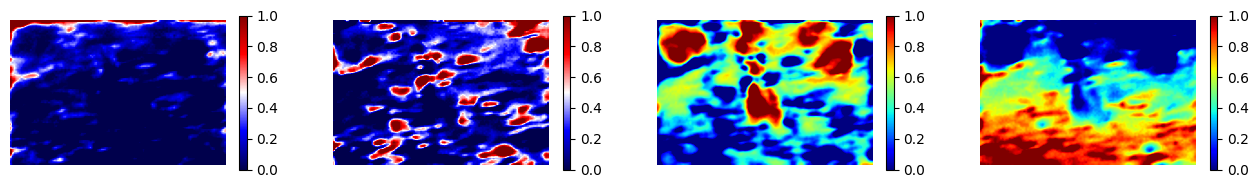

In [29]:
ans_arr = np.array(ans_arr)
print(ans_arr.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4), dpi=100)

im1 = ax1.imshow(ans_arr.reshape(d1,d2,4)[:,:,0], cmap='seismic', vmin = 0, vmax = 1)
ax1.axis(False)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.5)

im2 = ax2.imshow(ans_arr.reshape(d1,d2,4)[:,:,1], cmap='seismic', vmin = 0, vmax = 1)
ax2.axis(False)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.5)

im3 = ax3.imshow(ans_arr.reshape(d1,d2,4)[:,:,2], cmap='jet', interpolation='gaussian', vmin = 0, vmax = 1)
ax3.axis(False)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.5)

im4 = ax4.imshow(ans_arr.reshape(d1,d2,4)[:,:,3], cmap='jet', interpolation='gaussian', vmin = 0, vmax = 1)
ax4.axis(False)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.5)

plt.show()

And we can present results as an RGB image (note which components we have used as RGB channels)

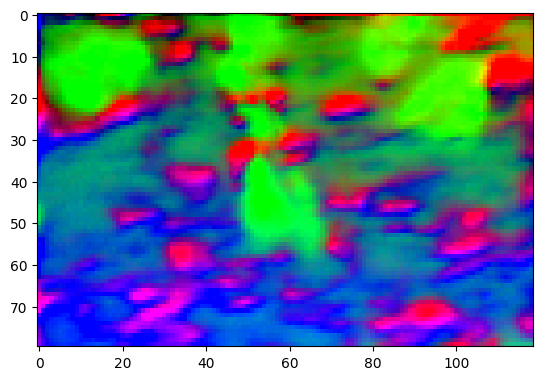

In [30]:
plt.imshow(ans_arr.reshape(d1,d2,4)[:,:,1:])

# LMFit

We can also use LMFit to fit our data using the set of Gaussian peaks.

In [31]:
! pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 5.8 MB/s eta 0:00:00


In [32]:
from lmfit.models import GaussianModel, ExponentialModel, ConstantModel

In [33]:
print(hdata.shape,wavelength.shape)
print(hdata.min(), hdata.max())

(80, 119, 128) (128,)
313.0 1514.75


-	An unknown asymmetric band with a peak position of 443(±10) nm
-	PbI2 peak: 505 (±7) nm
-	Perovskite peak: 745(±10) nm (Br-I mixed system), 787 (±10) nm (I-only system)


In [34]:
# Let's make it a function

def Gauss5Fit(x, y, if_plt):

  #Let's define search interval
  delta = 30
  cent1 = 443 #430
  cent2 = 505 #500
  cent3 = 550 #620
  cent4 = 720 #650
  cent5 = 800 #780

  const_mod = ConstantModel(prefix='const_')
  pars = const_mod.guess(y, x=x)
  # pars['const_c'].set(0.01, min=0, max = 0.02)

  gauss1  = GaussianModel(prefix='g1_')
  pars.update( gauss1.make_params())
  pars['g1_center'].set(cent1, min=cent1-delta, max=cent1+delta)
  pars['g1_sigma'].set(5, min=3, max = 50)
  pars['g1_amplitude'].set(2, min=0.01, max = 3000)

  gauss2  = GaussianModel(prefix='g2_')
  pars.update(gauss2.make_params())
  pars['g2_center'].set(cent2, min=cent2-delta, max=cent2+delta)
  pars['g2_sigma'].set(5, min=3, max = 40)
  pars['g2_amplitude'].set(2, min=0.01, max = 3000)

  gauss3  = GaussianModel(prefix='g3_')
  pars.update(gauss3.make_params())
  pars['g3_center'].set(cent3, min=cent3-2*delta, max=cent3+2*delta)
  pars['g3_sigma'].set(5, min=3, max = 80)
  pars['g3_amplitude'].set(2, min=0.01, max = 3000)

  gauss4  = GaussianModel(prefix='g4_')
  pars.update(gauss4.make_params())
  pars['g4_center'].set(cent4, min=cent4-3*delta, max=cent4+1*delta)
  pars['g4_sigma'].set(5, min=3, max = 70)
  pars['g4_amplitude'].set(2, min=0.01, max = 3000)

  gauss5  = GaussianModel(prefix='g5_')
  pars.update(gauss5.make_params())
  pars['g5_center'].set(cent5, min=cent5-1*delta, max=cent5+1*delta)
  pars['g5_sigma'].set(5, min=3, max = 45)
  pars['g5_amplitude'].set(2, min=1, max = 3000)

  mod2 = const_mod + gauss1 + gauss2 + gauss3 + gauss4 + gauss5
  init = mod2.eval(pars, x=x)
  out = mod2.fit(y, pars, x=x, method = 'slsqp') #method = 'slsqp' nelder
  #print(out.fit_report(min_correl=0.1))
  if if_plt:
    plt.plot(x, y)
    plt.plot(x, init, 'k--')
    plt.plot(x, out.best_fit, 'r-')
    plt.show()

  return out.values

Let's see how the fitted data at one location looks like

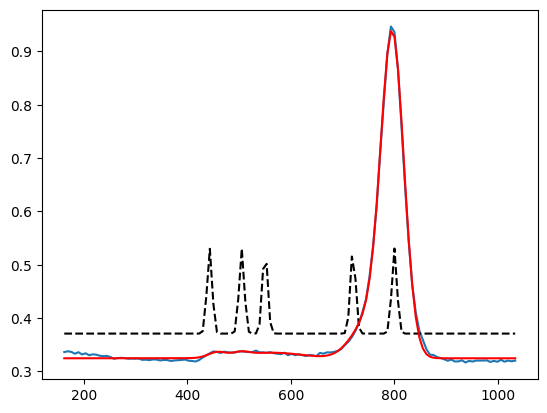

{'const_c': 0.3244872433969894,
 'g1_amplitude': 0.42754617752879526,
 'g1_center': 457.63557082689846,
 'g1_sigma': 16.950021522098503,
 'g1_fwhm': 39.914249680668,
 'g1_height': 0.010062893147195773,
 'g2_amplitude': 0.26352246514534644,
 'g2_center': 503.3147264370934,
 'g2_sigma': 15.67270147898993,
 'g2_fwhm': 36.90639089675507,
 'g2_height': 0.006707858149897573,
 'g3_amplitude': 1.5455563585011696,
 'g3_center': 563.3201631827225,
 'g3_sigma': 58.550603819160415,
 'g3_fwhm': 137.87613288543534,
 'g3_height': 0.01053085311202727,
 'g4_amplitude': 5.4352280455937185,
 'g4_center': 749.4961705166711,
 'g4_sigma': 32.12149576544259,
 'g4_fwhm': 75.64034065837951,
 'g4_height': 0.06750440245271642,
 'g5_amplitude': 32.99179430114397,
 'g5_center': 796.2517638332166,
 'g5_sigma': 22.21642599942298,
 'g5_fwhm': 52.315684271961224,
 'g5_height': 0.5924365287183058}

In [35]:
dat = hdata[50, 68, :]/1000 #10, 38
y = dat
x = wavelength

Gauss5Fit(x,y, True)

Let's look at several cross-sections

(80, 119, 128)


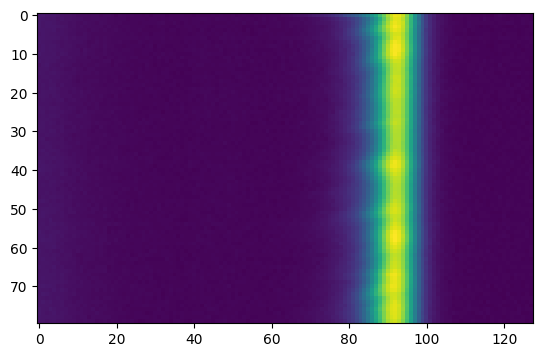

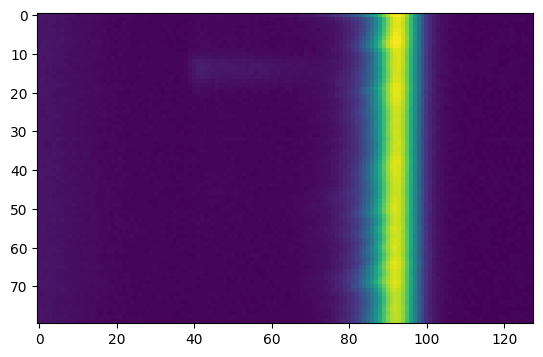

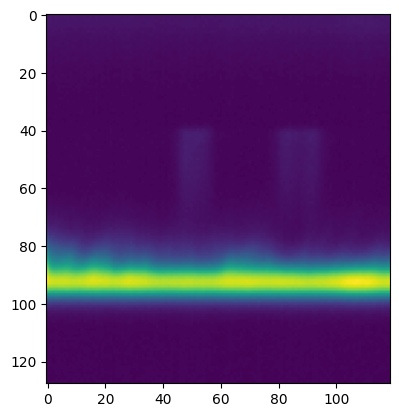

In [36]:
print(hdata.shape)

plt.imshow(np.log(hdata[:,33,:]))
plt.show()

plt.imshow(np.log(hdata[:,43,:]))
plt.show()

plt.imshow(np.log(hdata[1,:,:].T))
plt.show()

And fit all data (here we decimate it by factor of 5 - if you make step 1 or 2, you will have more points but code will take an hour to run).

0


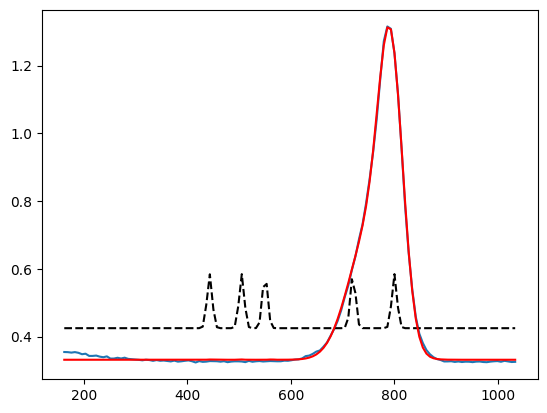

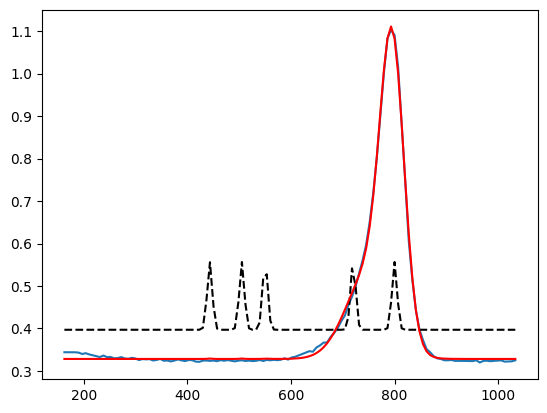

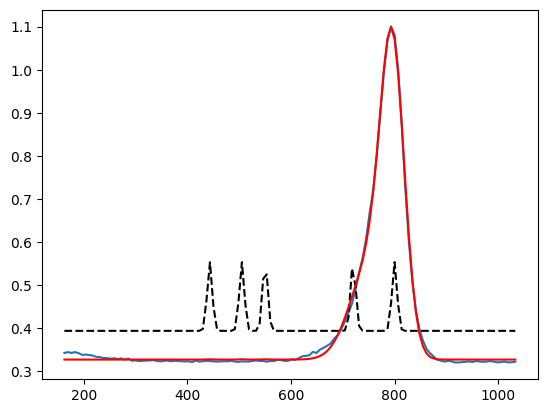

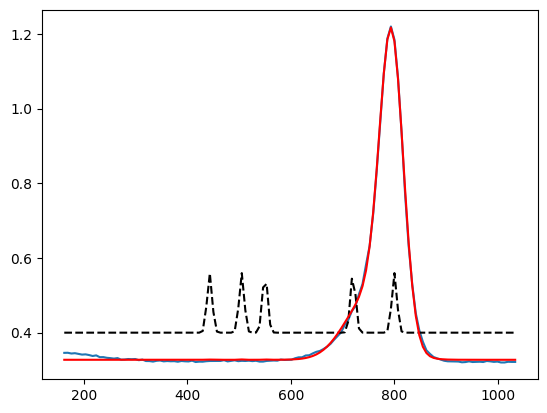

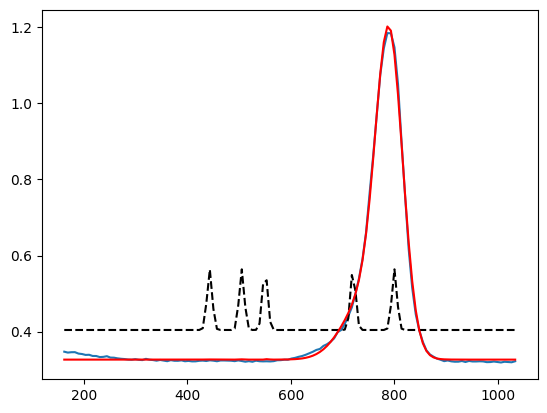

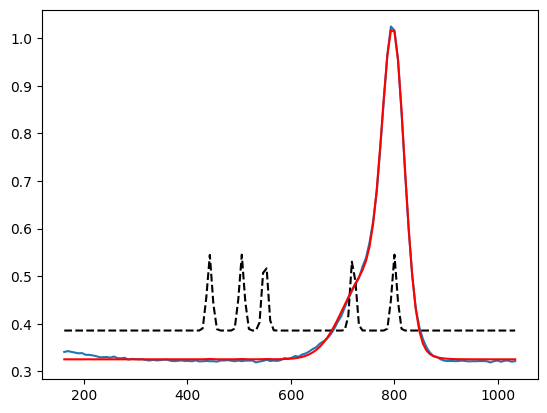

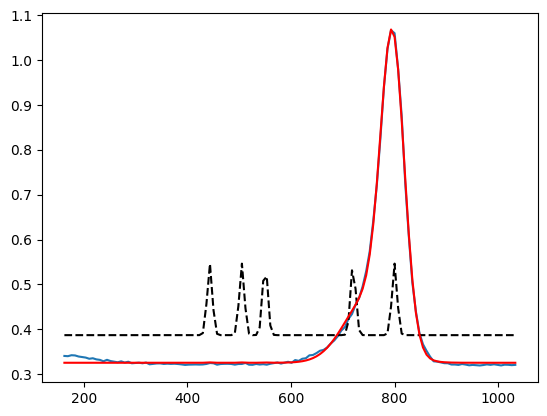

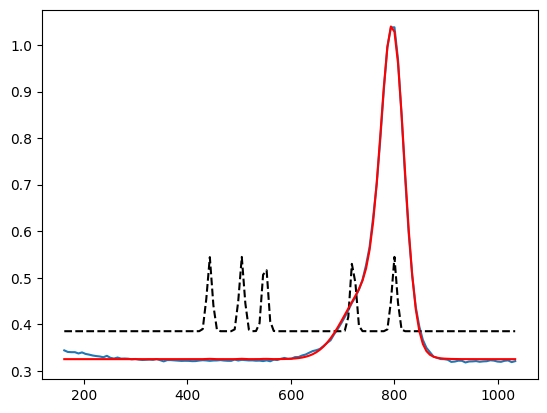

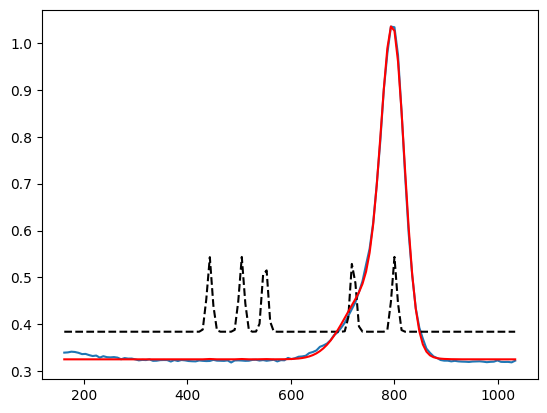

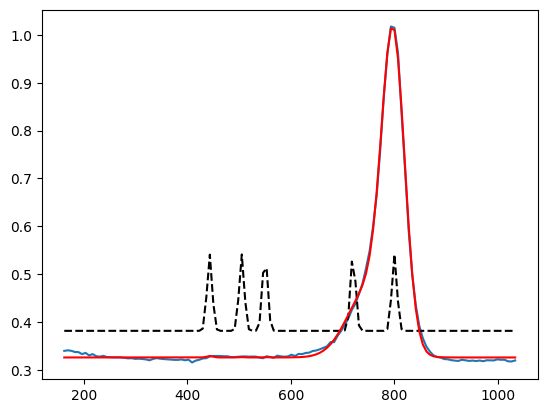

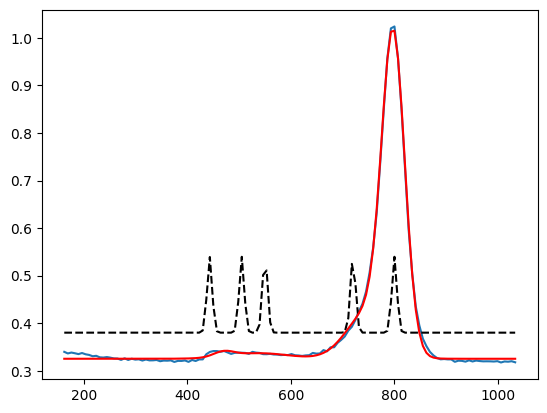

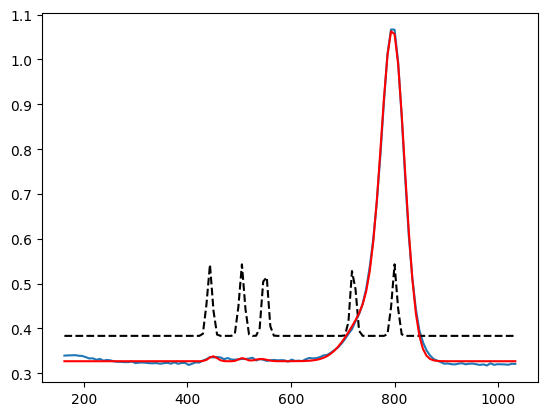

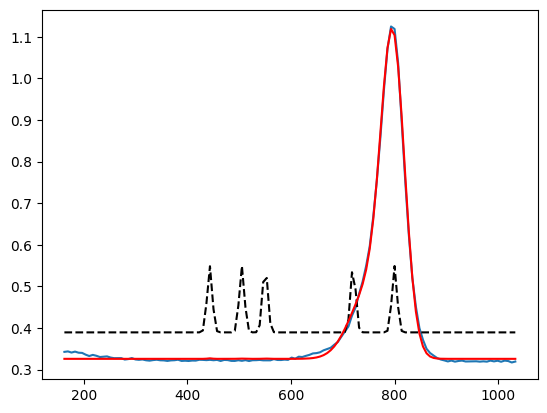

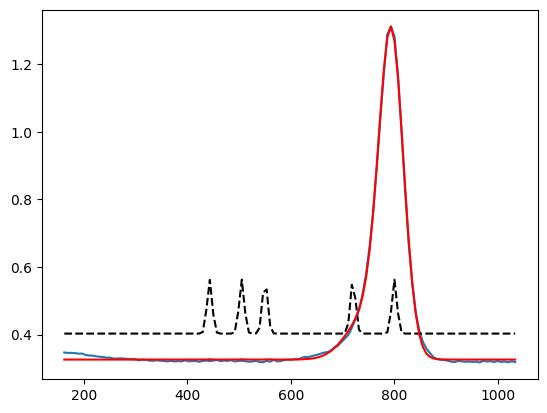

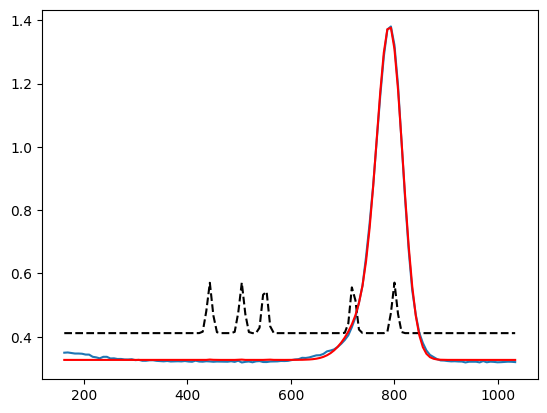

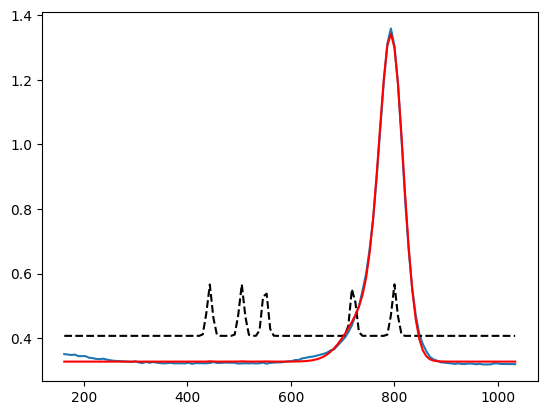

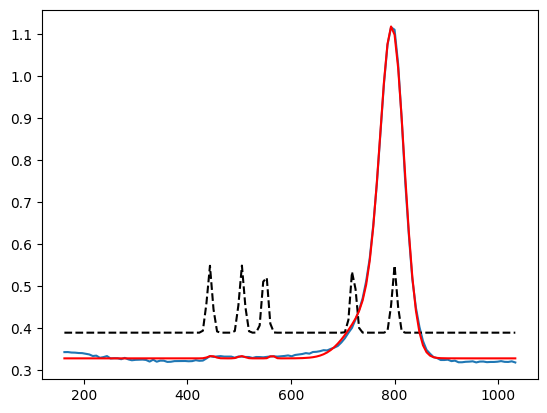

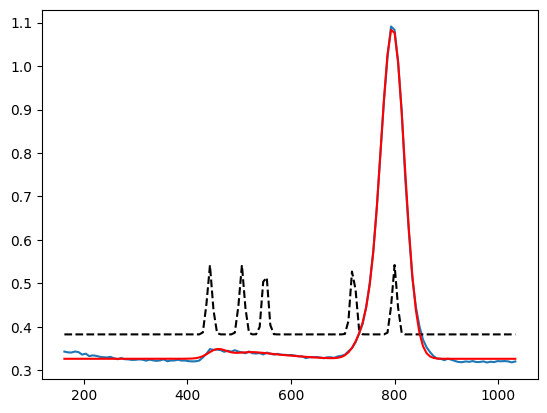

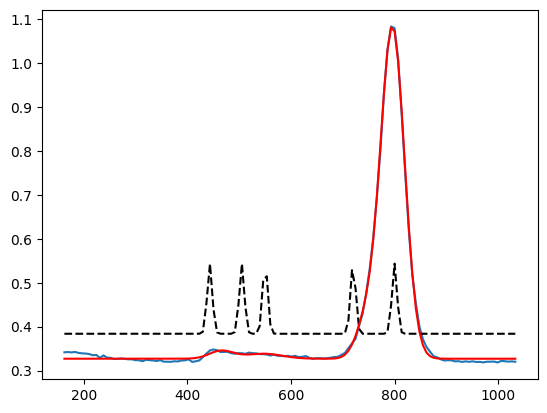

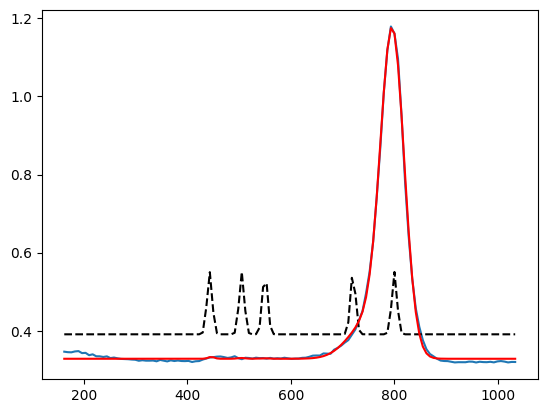

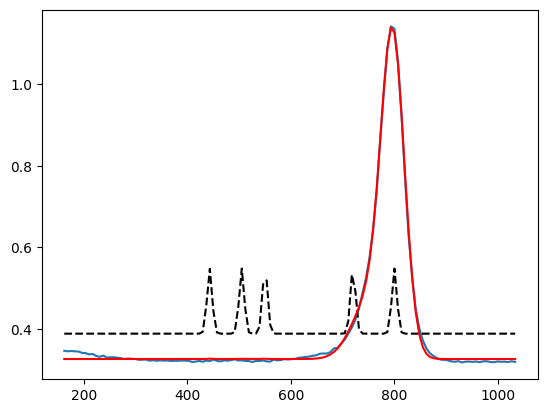

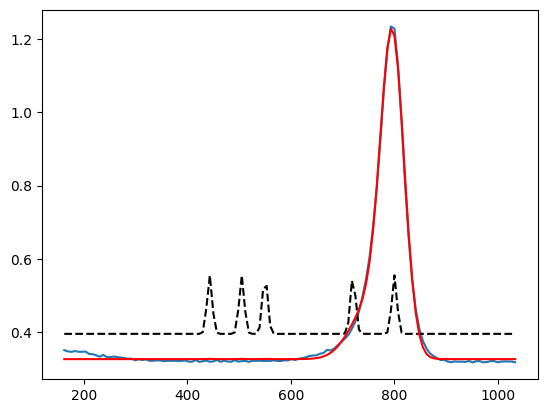

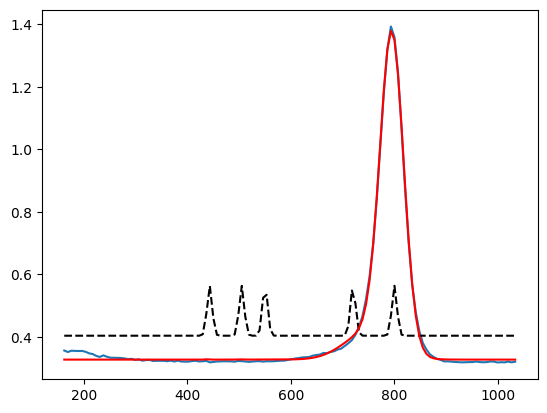

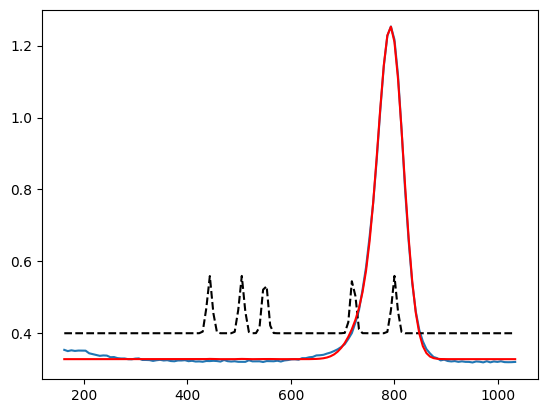

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [40]:
step = 5
dataset = hdata[::step,::step,:]/1000
result_arr = np.zeros((dataset.shape[0],dataset.shape[1],15))

for x in range(dataset.shape[0]):
  print(x)
  for y in range(dataset.shape[1]):
    temp = Gauss5Fit(wavelength, dataset[x,y,:], x == 0)
    result_arr[x,y,0] =  temp['g1_amplitude']
    result_arr[x,y,1] =  temp['g1_center']
    result_arr[x,y,2] =  temp['g1_sigma']
    result_arr[x,y,3] =  temp['g2_amplitude']
    result_arr[x,y,4] =  temp['g2_center']
    result_arr[x,y,5] =  temp['g2_sigma']
    result_arr[x,y,6] =  temp['g3_amplitude']
    result_arr[x,y,7] =  temp['g3_center']
    result_arr[x,y,8] =  temp['g3_sigma']
    result_arr[x,y,9] =  temp['g4_amplitude']
    result_arr[x,y,10] =  temp['g4_center']
    result_arr[x,y,11] =  temp['g4_sigma']
    result_arr[x,y,12] =  temp['g5_amplitude']
    result_arr[x,y,13] =  temp['g5_center']
    result_arr[x,y,14] =  temp['g5_sigma']

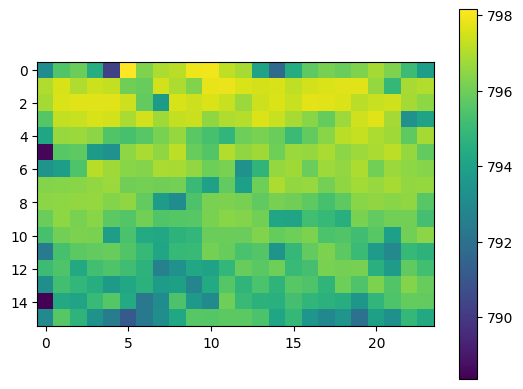

In [41]:
plt.imshow(result_arr[:,:,13])
plt.colorbar()
plt.show()

In [42]:
np.argmax(result_arr[:,:,0])

98

Now, plot maps of fit results!

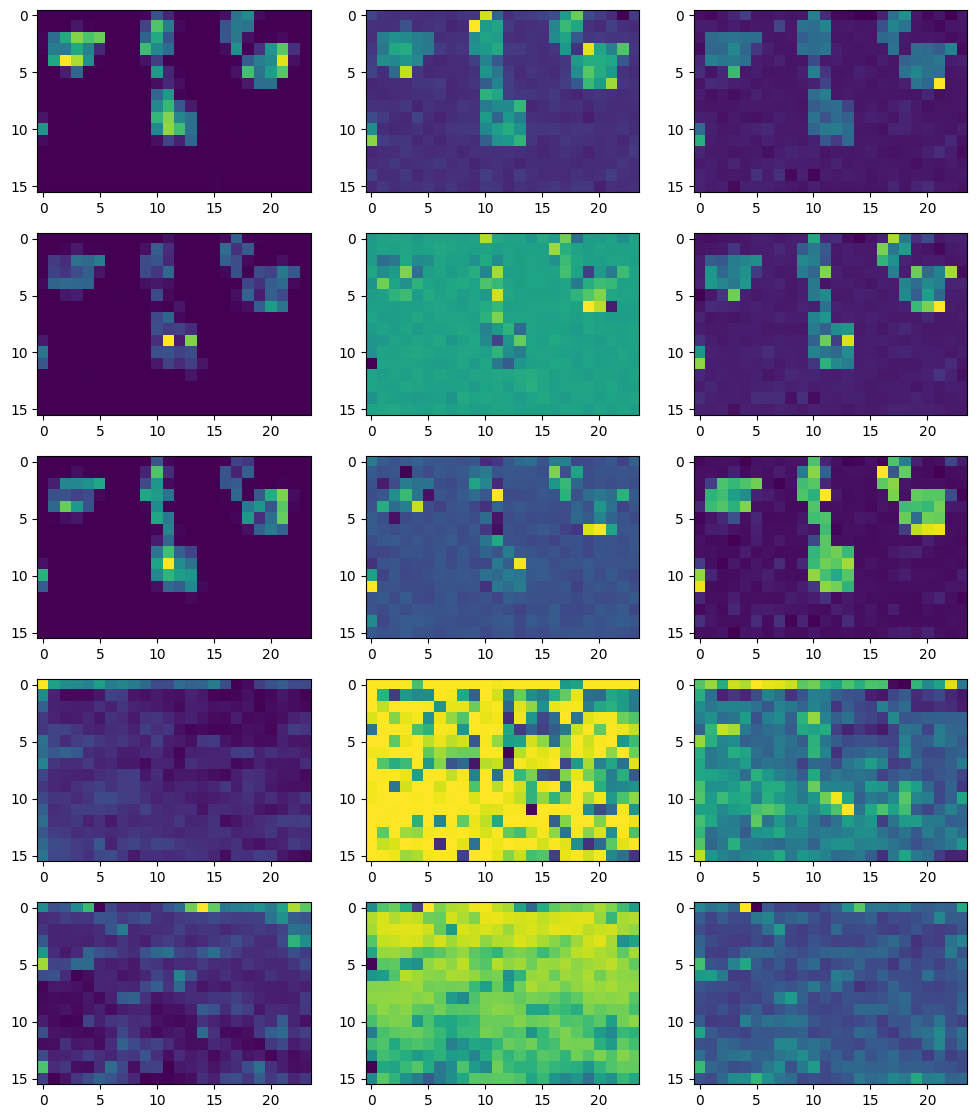

In [43]:
import matplotlib.gridspec as gridspec

rows = 5
cols = 3
gs1 = gridspec.GridSpec(rows, cols)

fig1 = plt.figure(figsize = (4*cols, 3.5*(1+rows)//1.5))
for i in range(rows*cols):
    ax1 = fig1.add_subplot(gs1[i])
    ax1.imshow(result_arr[:,:,i])
plt.show()

